In [106]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar-10/trainLabels.csv
/kaggle/input/cifar-10/sampleSubmission.csv
/kaggle/input/cifar-10/test.7z
/kaggle/input/cifar-10/train.7z


In [107]:
import os
import torch
import torchvision
import tarfile

In [108]:
from torchvision.datasets.utils import download_url

In [109]:
url="https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(url, '.') 

In [110]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path = './data')

In [112]:
data_dir="./data/cifar10"
print (os.listdir(data_dir))

classes=os.listdir(data_dir+'/train')
print (classes)

['train', 'test']
['truck', 'bird', 'frog', 'ship', 'airplane', 'automobile', 'dog', 'deer', 'cat', 'horse']


In [113]:
for type_class in classes:
    train_dir_path = f'./data/cifar10/train/{type_class}'
    test_dir_path= f'./data/cifar10/test/{type_class}'
    num_train = len(os.listdir(train_dir_path))
    num_test=len(os.listdir(test_dir_path))
    print(f"{type_class} => Training: {num_train} , Testing: {num_test}")

truck => Training: 5000 , Testing: 1000
bird => Training: 5000 , Testing: 1000
frog => Training: 5000 , Testing: 1000
ship => Training: 5000 , Testing: 1000
airplane => Training: 5000 , Testing: 1000
automobile => Training: 5000 , Testing: 1000
dog => Training: 5000 , Testing: 1000
deer => Training: 5000 , Testing: 1000
cat => Training: 5000 , Testing: 1000
horse => Training: 5000 , Testing: 1000


In [114]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

In [115]:
trans = transforms.Compose([
    # this operation was done, to make Image size compatible with AlexNet Model
    transforms.Resize((70,70)),
    # To focus on only primary component of Image
    transforms.RandomCrop((64,64)),
    transforms.ToTensor(),
    # To nullify dominance of one of Color channel
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [116]:
train_ds = ImageFolder(data_dir+'/train', transform = trans)
val_ds = ImageFolder(data_dir+'/test', transform = trans)

In [117]:
from torch.utils.data.dataloader import DataLoader

In [118]:
batch_size = 512
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)

In [119]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [120]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize = (12,12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[: 100], 10).permute(1,2,0))
        break

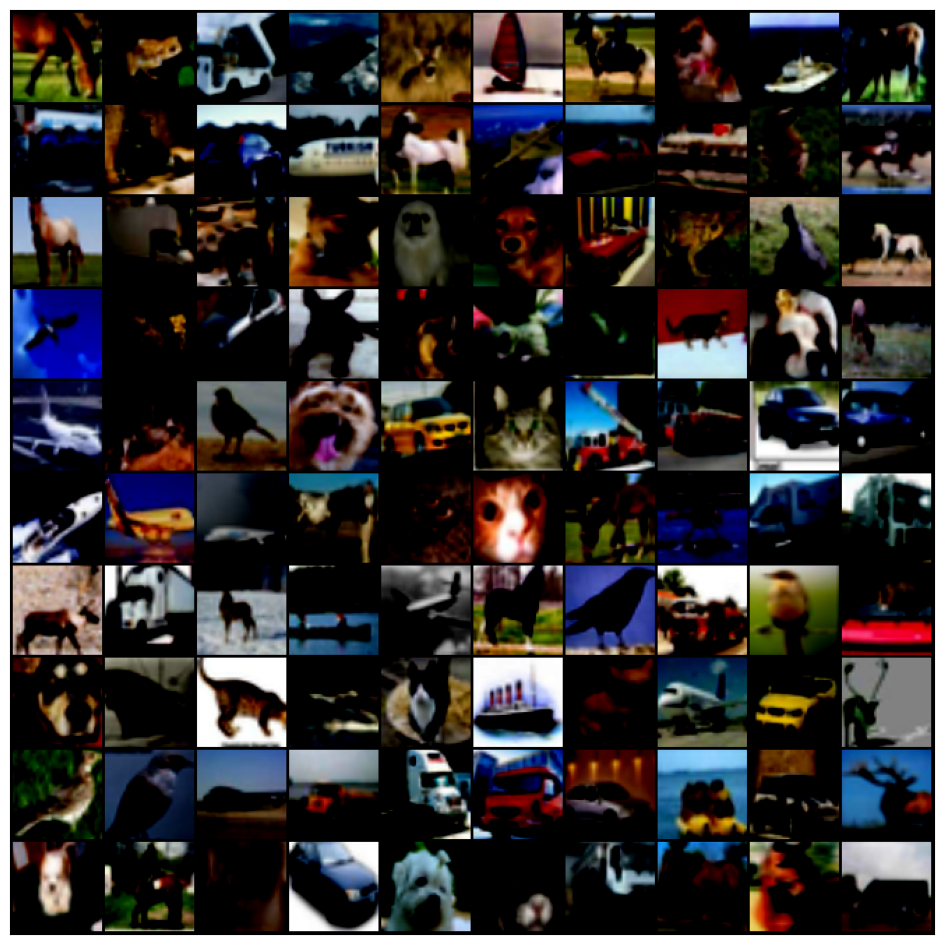

In [121]:
show_batch(train_dl)

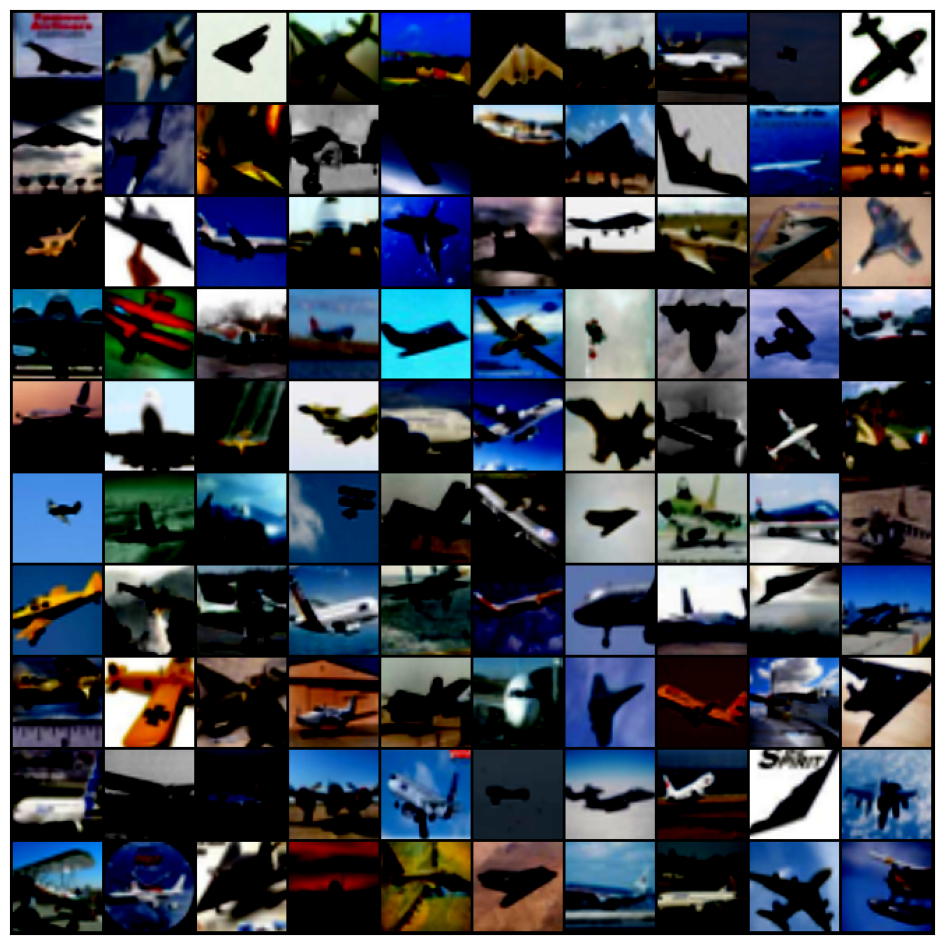

In [122]:
show_batch(valid_dl)

In [123]:
img, label = train_ds[0]
img.shape, label

(torch.Size([3, 64, 64]), 0)

In [124]:
import torch.nn as nn
import torch.nn.functional as F

In [125]:
class AlexNet(nn.Module):
    
    def __init__(self, num_classes):
        
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 11, stride = 4, padding = 2),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            
            nn.Conv2d(64, 192, kernel_size = 5, padding = 2),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            
            nn.Conv2d(192, 384, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(384, 256, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3, stride = 2)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace = True),
            
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            
            nn.Linear(4096, num_classes)
        )
        
    def forward(self, x):
        
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256*6*6)
        logit = self.classifier(x)
        
        return logit

In [126]:
model = AlexNet(num_classes = 10)

In [127]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [128]:
sample = next(iter(train_ds))
img = sample[0]
img.shape

torch.Size([3, 64, 64])

In [129]:
img.unsqueeze(0).shape

torch.Size([1, 3, 64, 64])

In [130]:
out = model(img.unsqueeze(0))

In [131]:
F.softmax(out)

/tmp/ipykernel_35/1665879703.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(out)


tensor([[0.1004, 0.1013, 0.0972, 0.0993, 0.1010, 0.1000, 0.0999, 0.1005, 0.0999,
         0.1004]], grad_fn=<SoftmaxBackward0>)

In [132]:
for images, labels in train_dl:
    print('Image Shape', images.shape)
    out = model(images)
    print('output shape', out.shape)
    print('out[0]', out[0])
    break

Image Shape torch.Size([512, 3, 64, 64])
output shape torch.Size([512, 10])
out[0] tensor([ 0.0108,  0.0199, -0.0172, -0.0008,  0.0172,  0.0099,  0.0063,  0.0078,
         0.0067,  0.0118], grad_fn=<SelectBackward0>)


In [133]:
probs = F.softmax(out[0], dim = 0)
probs

tensor([0.1003, 0.1013, 0.0976, 0.0992, 0.1010, 0.1003, 0.0999, 0.1001, 0.0999,
        0.1005], grad_fn=<SoftmaxBackward0>)

In [134]:
m = torch.argmax(probs)
m

tensor(1)

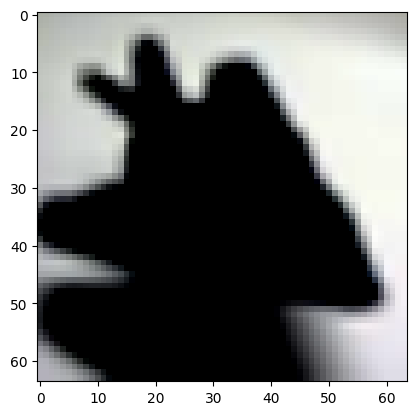

In [135]:
plt.imshow(img.permute(1,2,0))

In [136]:
sample[1]

0

In [137]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [138]:
device = get_default_device()
device

device(type='cuda')

In [139]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(valid_dl, device)
to_device(model, device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [140]:
def loss_batch(model, loss_func, x, y, opt = None, metric = None):
    
    pred = model(x)
    
    loss = loss_func(pred, y)
    
    if opt is not None:
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    metric_result = None
    
    if metric is not None:
        
        metric_result = metric(pred, y)
        
    return loss.item(), len(x), metric_result

In [141]:
def evaluate(model, loss_fn, val_dl, metric = None):
    
    with torch.no_grad():
        
        results = [loss_batch(model, loss_fn, x, y, metric = metric) for x, y in val_dl]
        
        losses, nums, metrics = zip(*results)
        
        total = np.sum(nums)
        
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        
        avg_metric = None
        
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
            
    return avg_loss, total, avg_metric

In [142]:
def fit(epochs, model, loss_fn, train_dl, val_dl, opt_fn = None, metric = None, scheduler = None, scheduler_on = 'val_metric'):
    
    train_losses, val_losses, val_metrics = [], [], []
    
    
    for epoch in range(epochs):
        
        model.train()
        for x, y in train_dl:
            train_loss, _, _ = loss_batch(model, loss_fn, x, y, opt_fn)
            
        model.eval()
        result = evaluate(model, loss_fn, val_dl, metric)
        val_loss, total, val_metric = result
        
        train_losses.append(train_loss)
        val_losses.append(val_losses)
        val_metrics.append(val_metric)
        
        if metric is None:
            print('Epoch{}/{}, train_loss: {:.4f}, val_loss: {:.4f}' 
                 .format(epoch+1, epochs, train_loss, val_loss))
            
        else:
            print('Epoch {}/{}, train_loss: {:.4f}, val_loss: {:.4f}, val_{}: {:.4f}'
                 .format(epoch+1, epochs, train_loss, val_loss, metric.__name__, val_metric))
            
        if scheduler is not None:
            if scheduler_on == 'val_metric':
                scheduler.step(val_metrics[-1])
        
            
    return train_losses, val_losses, val_metrics

In [143]:
def accuracy(output, labels):
    _, preds = torch.max(output, dim = 1)
    
    return torch.sum(preds == labels).item() / len(preds)

In [144]:
val_loss, _, val_acc = evaluate(model, F.cross_entropy, val_dl, metric = accuracy)

print(val_loss, val_acc)

2.302651505661011 0.0995


In [151]:
num_epochs = 35

optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, mode = 'max', verbose = True)

In [152]:
history = fit(num_epochs, model, F.cross_entropy, train_dl, val_dl, optimizer, accuracy, scheduler, 'val_metric')

Epoch 1/35, train_loss: 0.2925, val_loss: 0.9639, val_accuracy: 0.7471
Epoch 2/35, train_loss: 0.1961, val_loss: 0.9375, val_accuracy: 0.7566
Epoch 3/35, train_loss: 0.2050, val_loss: 0.9733, val_accuracy: 0.7481
Epoch 4/35, train_loss: 0.1760, val_loss: 1.0868, val_accuracy: 0.7386
Epoch 5/35, train_loss: 0.1791, val_loss: 1.0637, val_accuracy: 0.7455
Epoch 6/35, train_loss: 0.1830, val_loss: 1.0795, val_accuracy: 0.7460
Epoch 7/35, train_loss: 0.1453, val_loss: 1.2174, val_accuracy: 0.7418
Epoch 8/35, train_loss: 0.2109, val_loss: 1.2155, val_accuracy: 0.7436
Epoch 9/35, train_loss: 0.1774, val_loss: 1.1463, val_accuracy: 0.7504
Epoch 10/35, train_loss: 0.1806, val_loss: 1.1583, val_accuracy: 0.7397
Epoch 11/35, train_loss: 0.1617, val_loss: 1.1967, val_accuracy: 0.7424
Epoch 12/35, train_loss: 0.1022, val_loss: 1.2684, val_accuracy: 0.7427
Epoch 13/35, train_loss: 0.1449, val_loss: 1.2327, val_accuracy: 0.7518
Epoch 14/35, train_loss: 0.0280, val_loss: 1.2874, val_accuracy: 0.7566
E

Text(0.5, 1.0, 'Plot between Training Loss vs Epochs')

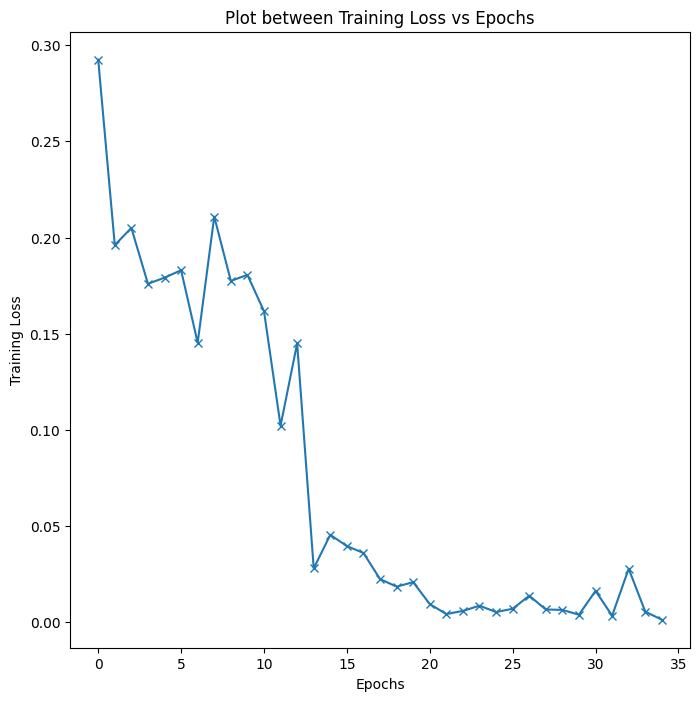

In [153]:
plt.figure(figsize = (8,8))
plt.plot(history[0], '-x')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Plot between Training Loss vs Epochs')

Text(0.5, 1.0, 'Plot between Validation Loss vs Epochs')

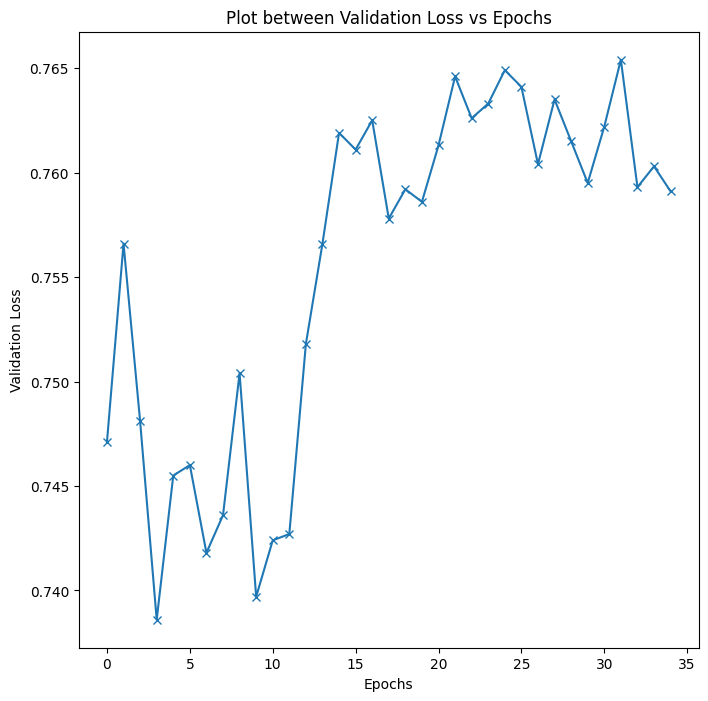

In [154]:
plt.figure(figsize = (8,8))
plt.plot(history[2], '-x')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Plot between Validation Loss vs Epochs')